In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import requests
import numpy as np
import time

import yfinance as yf
from pandas_datareader import data as pdr
from scipy.stats import norm
from IPython import display

## Helper Functions

In [2]:
def brand_glance(brand):
    i_brand = BAV_2019.index==brand
    quick_cols = ['Recommend_to_a_friend_pct', 'Brand_Stature_C', 'Brand_Strength_C']
    print(BAV_2019.iloc[i_brand][quick_cols])

In [3]:
def get_stock_data(ticker):
    """Uses a ticker symbol to pull financial data from Polygon API"""
    lookup_url = 'https://api.polygon.io/v2/reference/financials/'
    query = '?limit=3&type=T&apiKey=znY3_peGnZRXAcpXCeW3i2UVdCKz28Bq'
    stock_data = requests.get(lookup_url + ticker + query).json()
    
    return stock_data

In [4]:
def get_ticker_details(ticker):
    lookup_url = 'https://api.polygon.io/v1/meta/symbols/'
    query = '/company?&apiKey=znY3_peGnZRXAcpXCeW3i2UVdCKz28Bq'
    
    return requests.get(lookup_url + ticker + query).json()

In [5]:
def get_number_of_shares(ticker):
    """Uses a ticker symbol to pull the current number of shares from Yahoo Finance"""
    if not ticker:
        return None
    try:
        stock = yf.Tickers(ticker)
        return stock.tickers[0].info['sharesOutstanding']
    except:
        time.sleep(.1) # Slight pause every few calls so API doesn't timeout
        return None

In [11]:
def get_stock_prices(ticker, start_date, end_date):
    """Uses a ticker symbol to pull the stock price at a specific date from Yahoo Finance"""
    if not ticker:
        return None
    try:
        stock_prices_df = yf.download(tickers=ticker, start=start_date, end=end_date)
        begin_yr = stock_prices_df[0]['Adj Close']
        end_yr = stock_prices_df[-1]['Adj Close']
        return begin_yr, end_yr
    except:
        time.sleep(.1) # Slight pause every few calls so API doesn't timeout
        return None

## EDA

There's still a bit more clean up to do on the stock data from the data wrangling stage. The intent is to get all of the unique ticker symbols an use those to bring in the most relevant financial data.

In [13]:
# Load the Clean 2019 BAV data
BAV_2019 = pd.read_csv('../data/BAV_2019.csv', header=0, index_col=0)

# Load the Clean 2018 BAV data
BAV_2018 = pd.read_csv('../data/BAV_2018.csv', header=0, index_col=0)

In [14]:
BAV_2018.shape

(3522, 155)

***Problem:*** I want to get the number of columns down to something more reasonable. I only need the '_pct' columns for analysis, so will condense both years to just these columns and the other relevant string columns. This will reduce the dataframe from 150 columns, to less than 60.

***Note*** that the scale of the columns has changed. In the data wrangling phase, we were looking at percentile scores ('_R' columns) of the survey response data which was solving too much of the variation in our data to observe the true change. Switching to the raw, '_pct' columns allows us to see more of the true variability from year to year. These columns will be used going forward.

In [15]:
rel_cols = ['Brand_ID', 'Recommend_to_a_friend_pct', 'Energized_Differentiation_C', 'Relevance_C', 'Esteem_C', 'Knowledge_C', 'Brand_Stature_C', 'Brand_Strength_C', 'Different_pct', 'Distinctive_pct', 'Unique_pct', 'Dynamic_pct', 'Innovative_pct', 'Leader_pct', 'Reliable_pct', 'High_quality_pct', 'Arrogant_pct', 'Authentic_pct', 'Best_Brand_pct', 'Carefree_pct', 'Cares_Customers_pct', 'Charming_pct', 'Cool_pct', 'Creative_pct', 'Daring_pct', 'Down_to_Earth_pct', 'Energetic_pct', 'Friendly_pct', 'Fun_pct', 'Gaining_In_Popularity_pct', 'Glamorous_pct', 'Good_Value_pct', 'Healthy_pct', 'Helpful_pct', 'High_Performance_pct', 'Independent_pct', 'Intelligent_pct', 'Kind_pct', 'Original_pct', 'Prestigious_pct', 'Progressive_pct', 'Rugged_pct', 'Sensuous_pct', 'Simple_pct', 'Social_pct', 'Socially_Responsible_pct', 'Straightforward_pct', 'Stylish_pct', 'Traditional_pct', 'Trendy_pct', 'Trustworthy_pct', 'Unapproachable_pct', 'Up_To_Date_pct', 'Upper_Class_pct', 'Visionary_pct', 'Worth_More_pct', 'company', 'ticker_symbol']

In [16]:
BAV_2019_clean = BAV_2019[rel_cols]

BAV_2019_clean.shape
BAV_2019_clean.head(3)

,Brand_ID,Recommend_to_a_friend_pct,Energized_Differentiation_C,Relevance_C,Esteem_C,Knowledge_C,Brand_Stature_C,Brand_Strength_C,Different_pct,Distinctive_pct,...,Traditional_pct,Trendy_pct,Trustworthy_pct,Unapproachable_pct,Up_To_Date_pct,Upper_Class_pct,Visionary_pct,Worth_More_pct,company,ticker_symbol
Company 2019,,,,,,,,,,,,,,,,,,,,,
Acura,AVE,9.953999,0.642188,2.139913,0.539018,3.184861,1.716698,1.374227,8.288108,13.685770,...,8.759768,14.57190,16.129530,5.455859,11.924330,16.334471,12.20723,7.467402,Acura,NaN
Alfa Romeo,CQK,4.776871,0.762568,1.758157,0.317809,2.082544,0.661852,1.340714,9.912714,17.094549,...,7.273140,12.65383,8.988947,8.070658,9.083805,24.738430,10.36332,7.162646,Alfa Romeo,RMO
Aston Martin,MKU,5.559846,0.850419,1.654088,0.440287,2.108977,0.928555,1.406667,11.399390,19.736879,...,7.312238,13.29794,11.300640,10.102460,9.896882,28.885571,11.90374,7.692444,Aston Martin,NaN


In [17]:
BAV_2018_clean = BAV_2018[rel_cols]
BAV_2018_clean.head(3)

,Brand_ID,Recommend_to_a_friend_pct,Energized_Differentiation_C,Relevance_C,Esteem_C,Knowledge_C,Brand_Stature_C,Brand_Strength_C,Different_pct,Distinctive_pct,...,Traditional_pct,Trendy_pct,Trustworthy_pct,Unapproachable_pct,Up_To_Date_pct,Upper_Class_pct,Visionary_pct,Worth_More_pct,company,ticker_symbol
Company 2018,,,,,,,,,,,,,,,,,,,,,
Acura,AVE,9.632626,0.588681,2.131318,0.536944,3.303892,1.774005,1.254666,8.081687,12.271390,...,6.446314,14.55371,16.099440,5.703656,11.032270,15.302950,12.951940,6.352579,Acura,NaN
Alfa Romeo,CQK,5.360558,0.771191,1.648400,0.351125,2.040411,0.716439,1.271231,11.130420,17.817520,...,7.225183,14.87083,9.865144,10.311310,10.518590,25.941139,9.230522,8.130341,Alfa Romeo,RMO
Aston Martin,MKU,6.165359,0.777430,1.568270,0.347223,2.272228,0.788971,1.219220,11.082860,18.486561,...,5.149739,12.15355,9.925730,9.625601,7.878853,30.506660,10.001760,8.295667,Aston Martin,NaN


In [18]:
BAV_2019_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3661 entries, Acura to Gogo Inflight
Data columns (total 58 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Brand_ID                     3661 non-null   object 
 1   Recommend_to_a_friend_pct    3661 non-null   float64
 2   Energized_Differentiation_C  3661 non-null   float64
 3   Relevance_C                  3661 non-null   float64
 4   Esteem_C                     3661 non-null   float64
 5   Knowledge_C                  3661 non-null   float64
 6   Brand_Stature_C              3661 non-null   float64
 7   Brand_Strength_C             3661 non-null   float64
 8   Different_pct                3661 non-null   float64
 9   Distinctive_pct              3661 non-null   float64
 10  Unique_pct                   3661 non-null   float64
 11  Dynamic_pct                  3661 non-null   float64
 12  Innovative_pct               3661 non-null   float64
 13  Leader_pct

In [20]:
BAV_2019_clean.describe()

,Recommend_to_a_friend_pct,Energized_Differentiation_C,Relevance_C,Esteem_C,Knowledge_C,Brand_Stature_C,Brand_Strength_C,Different_pct,Distinctive_pct,Unique_pct,...,Straightforward_pct,Stylish_pct,Traditional_pct,Trendy_pct,Trustworthy_pct,Unapproachable_pct,Up_To_Date_pct,Upper_Class_pct,Visionary_pct,Worth_More_pct
count,3661.000000,3661.000000,3661.000000,3661.000000,3661.000000,3661.000000,3661.000000,3661.000000,3661.000000,3661.000000,...,3661.000000,3661.000000,3661.000000,3661.000000,3661.000000,3661.000000,3661.000000,3661.000000,3661.000000,3661.000000
mean,11.489829,0.599423,2.563751,0.469592,2.281783,1.216697,1.544480,9.667682,11.328327,9.828487,...,10.510167,8.074497,10.065465,12.360245,15.011998,5.599303,10.953085,8.134424,10.439582,6.280366
std,8.511323,0.121756,0.511106,0.204010,1.151295,1.105876,0.473453,2.566735,2.666646,2.634567,...,2.242157,4.457644,3.942529,4.350993,5.094438,2.389911,2.697314,4.281554,3.229588,2.498400
min,0.000000,0.311285,0.844490,0.040534,0.404155,0.060507,0.415449,3.170468,3.848764,3.395080,...,2.463440,1.510261,2.449850,2.655645,2.830153,0.000000,1.012154,0.646502,2.295802,0.000000
25%,5.298754,0.512744,2.237851,0.336072,1.232965,0.427885,1.220497,7.758272,9.569076,7.957906,...,9.008438,5.167236,7.388420,9.192031,11.343880,4.056057,9.142184,5.515210,8.229247,4.501060
50%,9.159182,0.582937,2.508065,0.416729,2.230872,0.843926,1.486404,9.214972,10.956990,9.430772,...,10.359760,6.616443,9.183610,11.598720,14.207090,5.047016,10.614800,6.940361,9.839184,5.842760
75%,15.871840,0.667548,2.814287,0.549660,3.177931,1.605285,1.798942,11.198800,12.645950,11.298210,...,11.848010,9.287068,11.752480,14.637160,17.949520,6.550036,12.445580,9.315038,12.030550,7.563744
max,50.524490,1.298806,5.316035,1.729260,5.400015,9.338032,6.904500,24.764650,28.001511,27.185499,...,26.774879,30.094561,44.155819,31.842150,36.037380,28.341579,25.543341,38.324921,31.832420,17.525881


### 1. Create New DataFrame for Stock Data

In [22]:
stock_data = pd.DataFrame()
stock_data['ticker_symbol'] = BAV_2019_clean['ticker_symbol']

In [23]:
stock_data.head()

,ticker_symbol
Company 2019,
Acura,NaN
Alfa Romeo,RMO
Aston Martin,NaN
Audi,NaN
Bentley,BSY


In [ ]:
stock_data['total_shares'] = BAV_2019_clean['ticker_symbol'].apply(lambda x: None if x is np.NaN else get_number_of_shares(x))

In [22]:
stock_data.sample(10)

,ticker_symbol,total_shares
Company 2019,,
Restasis,NaN,NaN
TrueCar,TRUE,98495400.0
Intermix,NaN,NaN
FabFitFun,NaN,NaN
Ore-Ida,IDA,50469200.0
YouTube Music,NaN,NaN
Related Rentals,URI,72330096.0
Enterprise Rent-A-Car,CARS,67414704.0
Pepsi,NaN,NaN


In [28]:
stock_data['ticker_symbol'].notnull().value_counts()

True     1857
False    1804
Name: ticker_symbol, dtype: int64

In [29]:
stock_data['ticker_symbol'].sort_values(ascending=False).value_counts()

S        150
COMS      51
NEW       22
GOOGL     20
UVV       16
        ... 
SASR       1
PAG        1
CROX       1
TIVO       1
TEG        1
Name: ticker_symbol, Length: 870, dtype: int64

***Problem:*** The ticker data is too sparce and inaccurate to be valuable. We know that we've matched a little more than 50% of the companies in our set. Of those, many are duplicates that will have to be dealt with. While that's all addressable, the biggest problem is the inacuracy: We can see from the sample of the dataframe above that the brand 'Ore-Ida' was matches as ticker IDA. I happen to know that Ore-Ida (the frozen potato brand) is part of the Kraft-Heinz company and should not have its own ticker symbol. A quick Google search verifies this issue.

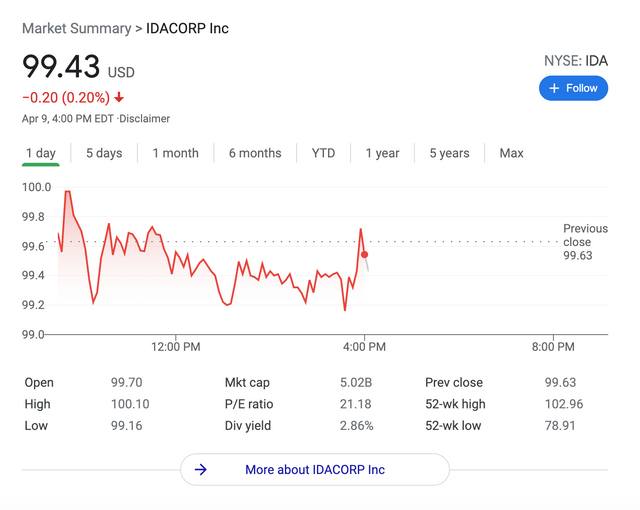

In [35]:
display.Image("https://i.ibb.co/vLrf9TG/Screen-Shot-2021-04-12-at-4-27-37-AM.png")

***Note:*** The working hypothesis to this point was that market capitalization, or more specifically, the percentage delta in annual market capitalization would be the ultimate target feature for prediction. Getting this specific feature cleanly into the dataframe in line with the other independent variables in the set is too inacurate programatically. To verify each of the companies individually would not be worth the effort. It's time to make a shift in the target variable.

### 2. Changing the Target Variable

##### Option B: Recommend to a Friend

Let's start by taking a deeper look at the target feature and then how our other survey response data is distributed.

In [36]:
BAV_2019_clean['Recommend_to_a_friend_pct'].describe()

count    3661.000000
mean       11.489829
std         8.511323
min         0.000000
25%         5.298754
50%         9.159182
75%        15.871840
max        50.524490
Name: Recommend_to_a_friend_pct, dtype: float64

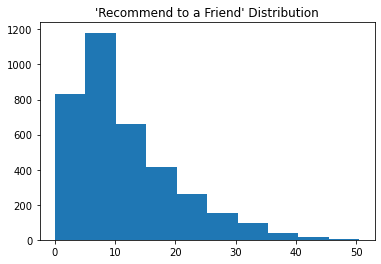

In [45]:
plt.hist(BAV_2019_clean['Recommend_to_a_friend_pct'])
plt.title("'Recommend to a Friend' Distribution")
plt.show()

With a tiny bit of cleaning, this looks like a good option. The min value (0.0) represents no recomendations. This will skew the results and we should drop all brands with no recomendations. Let's do that below then ensure we have a min value above 0 before continuing.

In [38]:
zero_recos_2019 = BAV_2019_clean.loc[BAV_2019_clean['Recommend_to_a_friend_pct']==0]
zero_recos_2018 = BAV_2018_clean.loc[BAV_2018_clean['Recommend_to_a_friend_pct']==0]
print(len(zero_recos_2019))
print(len(zero_recos_2018))

240
222


In [39]:
BAV_2019 = BAV_2019_clean.drop(zero_recos_2019.index, axis=0)
BAV_2018 = BAV_2018_clean.drop(zero_recos_2018.index, axis=0)

In [40]:
BAV_2019['Recommend_to_a_friend_pct'].describe()

count    3421.000000
mean       12.295897
std         8.222656
min         1.821036
25%         5.946419
50%         9.824226
75%        16.470011
max        50.524490
Name: Recommend_to_a_friend_pct, dtype: float64

In [41]:
BAV_2018['Recommend_to_a_friend_pct'].describe()

count    3300.000000
mean       12.386533
std         8.349075
min         1.825505
25%         6.087589
50%         9.842733
75%        16.440258
max        49.054710
Name: Recommend_to_a_friend_pct, dtype: float64

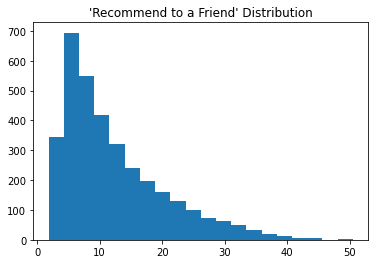

In [46]:
plt.hist(BAV_2019['Recommend_to_a_friend_pct'], bins=20)
plt.title("'Recommend to a Friend' Distribution")
plt.show()

Much better. Dropping these ~240 observations helps tremendously and looks like we still have a workable distribution. Now let's get these years lined up by retaining only the companies that are present in both years.

#### Merging the 2018 and 2019 Data

Start by dropping the stock data from the relevant columns

In [51]:
rel_cols = ['Recommend_to_a_friend_pct', 'Energized_Differentiation_C', 'Relevance_C', 'Esteem_C', 'Knowledge_C', 'Brand_Stature_C', 'Brand_Strength_C', 'Different_pct', 'Distinctive_pct', 'Unique_pct', 'Dynamic_pct', 'Innovative_pct', 'Leader_pct', 'Reliable_pct', 'High_quality_pct', 'Arrogant_pct', 'Authentic_pct', 'Best_Brand_pct', 'Carefree_pct', 'Cares_Customers_pct', 'Charming_pct', 'Cool_pct', 'Creative_pct', 'Daring_pct', 'Down_to_Earth_pct', 'Energetic_pct', 'Friendly_pct', 'Fun_pct', 'Gaining_In_Popularity_pct', 'Glamorous_pct', 'Good_Value_pct', 'Healthy_pct', 'Helpful_pct', 'High_Performance_pct', 'Independent_pct', 'Intelligent_pct', 'Kind_pct', 'Original_pct', 'Prestigious_pct', 'Progressive_pct', 'Rugged_pct', 'Sensuous_pct', 'Simple_pct', 'Social_pct', 'Socially_Responsible_pct', 'Straightforward_pct', 'Stylish_pct', 'Traditional_pct', 'Trendy_pct', 'Trustworthy_pct', 'Unapproachable_pct', 'Up_To_Date_pct', 'Upper_Class_pct', 'Visionary_pct', 'Worth_More_pct']

In [ ]:
BAV_2018 = BAV_2018.drop(['Brand_ID', 'company', 'ticker_symbol'], axis=1)

In [62]:
BAV_2019 = BAV_2019.drop(['Brand_ID', 'company', 'ticker_symbol'], axis=1)

In [63]:
BAV_2019.head()

,Recommend_to_a_friend_pct,Energized_Differentiation_C,Relevance_C,Esteem_C,Knowledge_C,Brand_Stature_C,Brand_Strength_C,Different_pct,Distinctive_pct,Unique_pct,...,Straightforward_pct,Stylish_pct,Traditional_pct,Trendy_pct,Trustworthy_pct,Unapproachable_pct,Up_To_Date_pct,Upper_Class_pct,Visionary_pct,Worth_More_pct
Company 2019,,,,,,,,,,,,,,,,,,,,,
Acura,9.953999,0.642188,2.139913,0.539018,3.184861,1.716698,1.374227,8.288108,13.685770,8.809677,...,9.458297,15.892970,8.759768,14.57190,16.129530,5.455859,11.924330,16.334471,12.20723,7.467402
Alfa Romeo,4.776871,0.762568,1.758157,0.317809,2.082544,0.661852,1.340714,9.912714,17.094549,12.282400,...,8.145388,16.810770,7.273140,12.65383,8.988947,8.070658,9.083805,24.738430,10.36332,7.162646
Aston Martin,5.559846,0.850419,1.654088,0.440287,2.108977,0.928555,1.406667,11.399390,19.736879,14.658690,...,7.946951,19.329081,7.312238,13.29794,11.300640,10.102460,9.896882,28.885571,11.90374,7.692444
Audi,9.149771,0.769728,2.099322,0.567456,3.103108,1.760876,1.615906,9.106336,16.300961,11.311780,...,7.745929,21.346279,7.943208,15.87654,15.379080,6.150225,11.646320,26.495449,11.09996,7.660220
Bentley,6.758671,0.767631,1.696136,0.482285,2.661824,1.283759,1.302006,10.520440,18.429020,12.581550,...,7.727577,17.727449,10.515710,11.63354,11.235060,9.541951,9.916174,35.123810,10.46475,10.152610


Now lets get both years into the same shape and matched on the index.

In [64]:
BAV_merge = pd.merge(BAV_2019, BAV_2018, left_index=True, right_index=True)

In [65]:
BAV_merge.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2869 entries, Acura to Thomson Reuters
Columns: 110 entries, Recommend_to_a_friend_pct_x to Worth_More_pct_y
dtypes: float64(110)
memory usage: 2.4+ MB


In [66]:
BAV_merge.head()

,Recommend_to_a_friend_pct_x,Energized_Differentiation_C_x,Relevance_C_x,Esteem_C_x,Knowledge_C_x,Brand_Stature_C_x,Brand_Strength_C_x,Different_pct_x,Distinctive_pct_x,Unique_pct_x,...,Straightforward_pct_y,Stylish_pct_y,Traditional_pct_y,Trendy_pct_y,Trustworthy_pct_y,Unapproachable_pct_y,Up_To_Date_pct_y,Upper_Class_pct_y,Visionary_pct_y,Worth_More_pct_y
Acura,9.953999,0.642188,2.139913,0.539018,3.184861,1.716698,1.374227,8.288108,13.685770,8.809677,...,8.849539,15.710160,6.446314,14.55371,16.099440,5.703656,11.032270,15.302950,12.951940,6.352579
Alfa Romeo,4.776871,0.762568,1.758157,0.317809,2.082544,0.661852,1.340714,9.912714,17.094549,12.282400,...,6.080796,17.267210,7.225183,14.87083,9.865144,10.311310,10.518590,25.941139,9.230522,8.130341
Aston Martin,5.559846,0.850419,1.654088,0.440287,2.108977,0.928555,1.406667,11.399390,19.736879,14.658690,...,6.469045,16.646311,5.149739,12.15355,9.925730,9.625601,7.878853,30.506660,10.001760,8.295667
Audi,9.149771,0.769728,2.099322,0.567456,3.103108,1.760876,1.615906,9.106336,16.300961,11.311780,...,10.260040,18.800541,8.386318,15.85582,12.400040,6.730000,10.951970,21.809719,11.357830,8.388798
Bentley,6.758671,0.767631,1.696136,0.482285,2.661824,1.283759,1.302006,10.520440,18.429020,12.581550,...,7.434486,19.569870,11.032830,12.52582,12.685470,11.473560,9.141562,34.941780,9.720911,10.133530


Split the dataframe so they can be referenced by single year. Ensure all remaining columns are strictly numerical.

In [67]:
BAV_2019_clean = BAV_merge.iloc[:, 0:55]
BAV_2018_clean = BAV_merge.iloc[:, 55:]

In [68]:
BAV_2019_clean.columns = rel_cols
BAV_2018_clean.columns = rel_cols
BAV_2019_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2869 entries, Acura to Thomson Reuters
Data columns (total 55 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Recommend_to_a_friend_pct    2869 non-null   float64
 1   Energized_Differentiation_C  2869 non-null   float64
 2   Relevance_C                  2869 non-null   float64
 3   Esteem_C                     2869 non-null   float64
 4   Knowledge_C                  2869 non-null   float64
 5   Brand_Stature_C              2869 non-null   float64
 6   Brand_Strength_C             2869 non-null   float64
 7   Different_pct                2869 non-null   float64
 8   Distinctive_pct              2869 non-null   float64
 9   Unique_pct                   2869 non-null   float64
 10  Dynamic_pct                  2869 non-null   float64
 11  Innovative_pct               2869 non-null   float64
 12  Leader_pct                   2869 non-null   float64
 13  Reliable

In [73]:
BAV_2019_clean.describe()

,Recommend_to_a_friend_pct,Energized_Differentiation_C,Relevance_C,Esteem_C,Knowledge_C,Brand_Stature_C,Brand_Strength_C,Different_pct,Distinctive_pct,Unique_pct,...,Straightforward_pct,Stylish_pct,Traditional_pct,Trendy_pct,Trustworthy_pct,Unapproachable_pct,Up_To_Date_pct,Upper_Class_pct,Visionary_pct,Worth_More_pct
count,2869.000000,2869.000000,2869.000000,2869.000000,2869.000000,2869.000000,2869.000000,2869.000000,2869.000000,2869.000000,...,2869.000000,2869.000000,2869.000000,2869.000000,2869.000000,2869.000000,2869.000000,2869.000000,2869.000000,2869.000000
mean,12.895487,0.591010,2.560883,0.479942,2.426040,1.314979,1.521053,9.438163,11.320186,9.660196,...,10.496746,8.075805,10.118159,12.395033,15.276391,5.296906,10.969095,8.006291,10.234340,6.385033
std,8.377199,0.119222,0.528508,0.211048,1.124777,1.144105,0.477069,2.425439,2.628329,2.548338,...,2.139809,4.606407,3.810070,4.378784,5.179453,1.967503,2.671048,4.426401,3.147666,2.525244
min,1.829373,0.311285,1.083304,0.078267,0.451745,0.103558,0.415449,3.170468,3.903857,3.395080,...,3.729762,1.510261,3.453261,3.591598,3.428540,0.000000,1.012154,0.777813,2.295802,0.819163
25%,6.443789,0.507066,2.211841,0.338630,1.430258,0.499309,1.197177,7.633588,9.593768,7.874441,...,9.030857,5.126696,7.423224,9.169734,11.537430,3.964717,9.138504,5.429312,8.076599,4.549795
50%,10.417610,0.575796,2.484509,0.422114,2.420009,0.957879,1.452264,9.010921,10.920810,9.252584,...,10.355190,6.466500,9.269544,11.570190,14.451960,4.865730,10.571810,6.687207,9.641481,5.928324
75%,17.309530,0.653805,2.829619,0.566995,3.298582,1.716698,1.757115,10.839110,12.612930,11.024330,...,11.818550,9.187174,11.856600,14.674650,18.395090,6.243865,12.403130,8.939644,11.679310,7.693806
max,50.524490,1.298806,5.316035,1.729260,5.400015,9.338032,6.904500,23.264080,28.001511,27.185499,...,24.433090,30.094561,27.731979,31.842150,35.576180,26.946779,23.699970,38.324921,30.763710,17.525881


Target variable and dataframe is now all cleaned up and appears to be more consistently disributed Let's visualize this with some of the features. Aside from the '_C' columns, everything is nicely scaled.

In [69]:
#Summary Columns
stature_and_strength = ['Recommend_to_a_friend_pct', 'Brand_Stature_C', 'Brand_Strength_C']
summary_cols = ['Recommend_to_a_friend_pct', 'Energized_Differentiation_C', 'Relevance_C', 'Esteem_C', 'Knowledge_C']

### 3. Visualizations

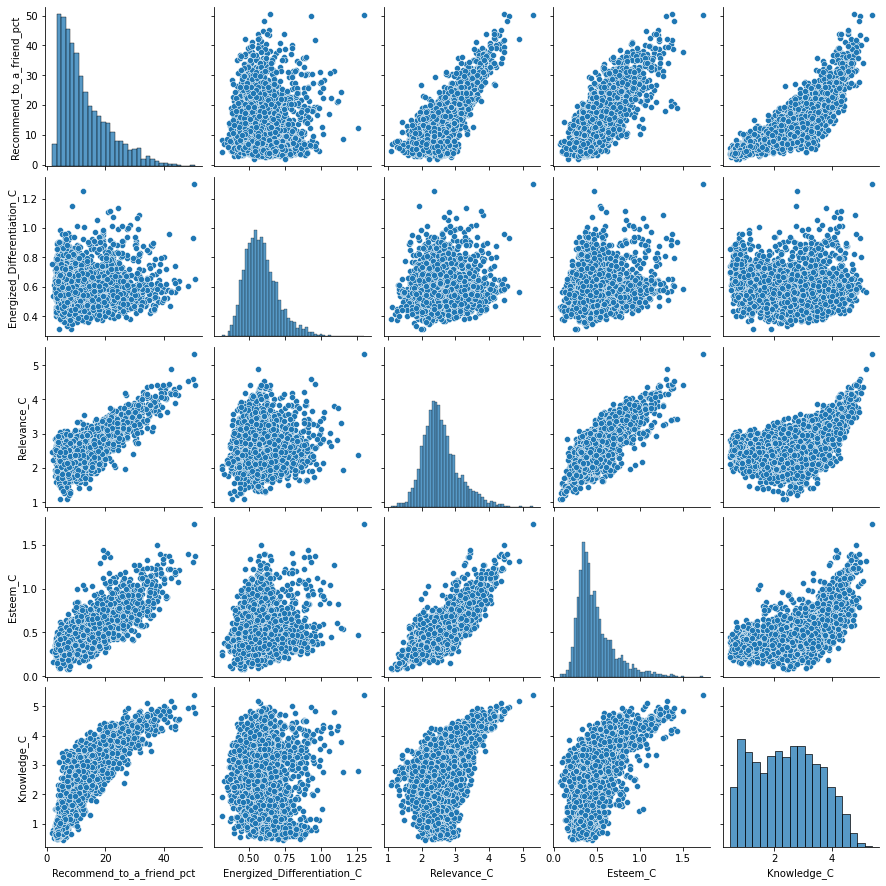

In [70]:
#Pairplot of features
_ = sns.pairplot(BAV_2019_clean[summary_cols])
plt.show()

There appears to be some good correlation happening with many of these features moving together. It's hard to tell with the scatterplots—let's draw some heat maps to get a better look.

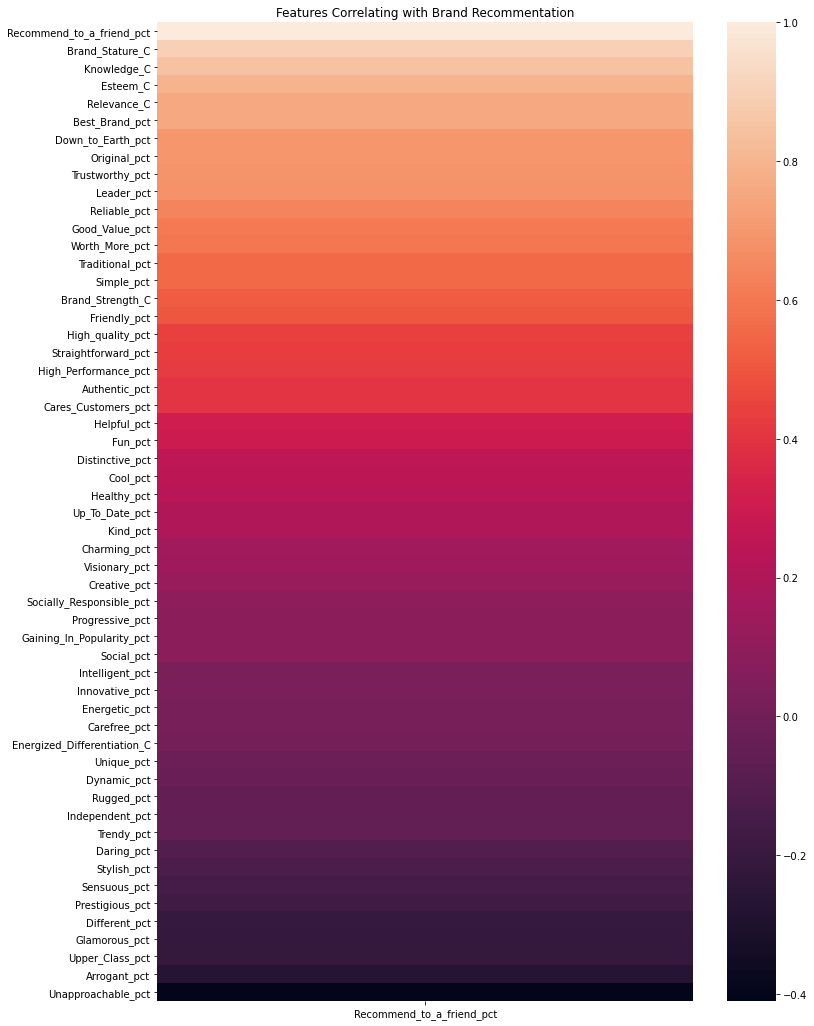

In [71]:
plt.figure(figsize=(12, 18))
heatmap = sns.heatmap(BAV_2019_clean.corr()[['Recommend_to_a_friend_pct']].sort_values(by='Recommend_to_a_friend_pct', ascending=False))
heatmap.set_title('Features Correlating with Brand Recommentation')
plt.show()

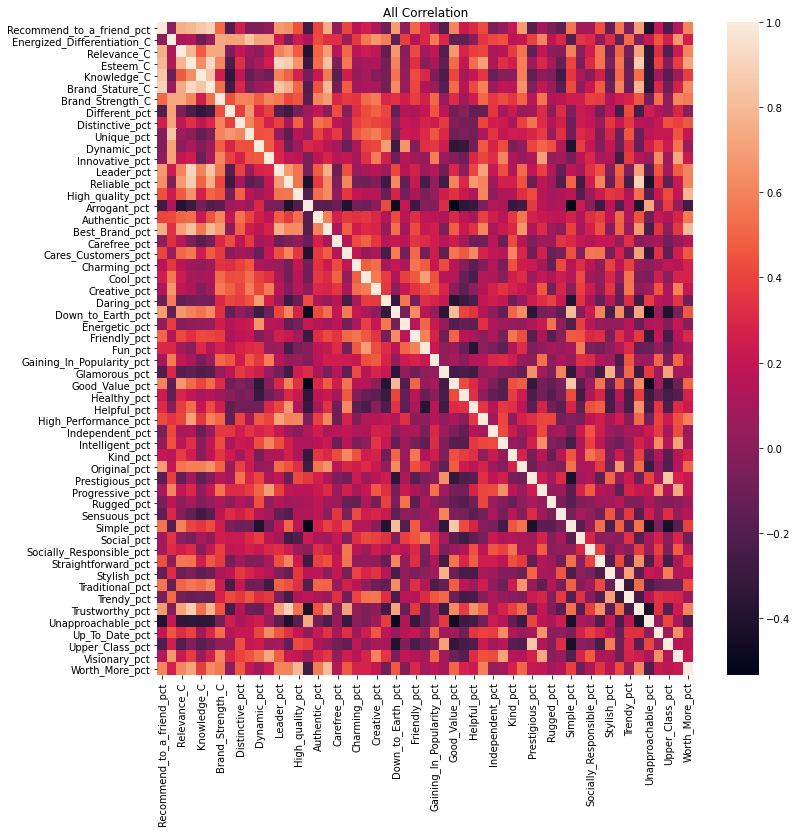

In [72]:
plt.figure(figsize=(12, 12))
heatmap = sns.heatmap(BAV_2019_clean.corr())
heatmap.set_title('All Correlation')
plt.show()

There is a lot to take in here. When looking at what moves with the target variable, there are some features that rise to the top. The '_C' attributes of Esteem, Relevance, Knowledge and Stretgth rise to the top with some others like the perception of being 'Trustworthy', 'Original' and 'Down to Earth' playing a role as well. As well, attributes like 'Arrogance' and 'Unapproachable' could be good negative correlators for the model. In the middle it's pretty muddy and there's a lot of overlap. This can be seen in the eye-chart of the full correlation heat map. This will have to be addressed in the Feature Engineering phase. Potentially conducting a PCA to reduce or consolodate the number of features.

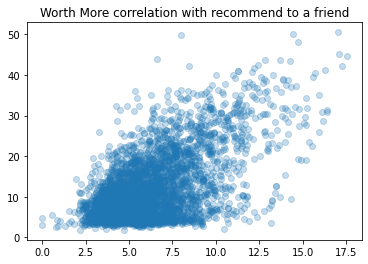

In [76]:
plt.scatter(BAV_2019['Worth_More_pct'], BAV_2019['Recommend_to_a_friend_pct'], alpha=.25)
plt.title('Worth More correlation with recommend to a friend')
plt.show()

/Users/jerryroback/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


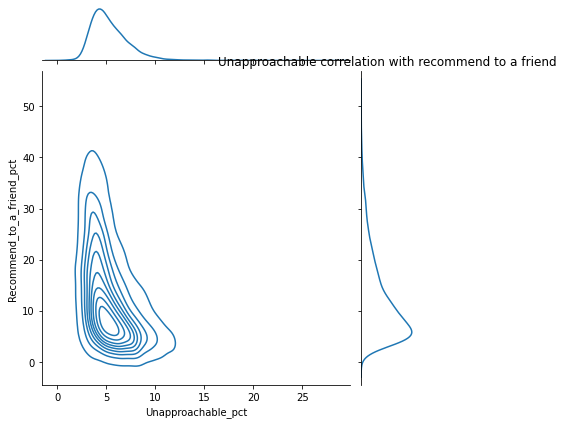

In [77]:
sns.jointplot(BAV_2019['Unapproachable_pct'], BAV_2019['Recommend_to_a_friend_pct'], kind = 'kde')
plt.title('Unapproachable correlation with recommend to a friend')
plt.show()

/Users/jerryroback/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


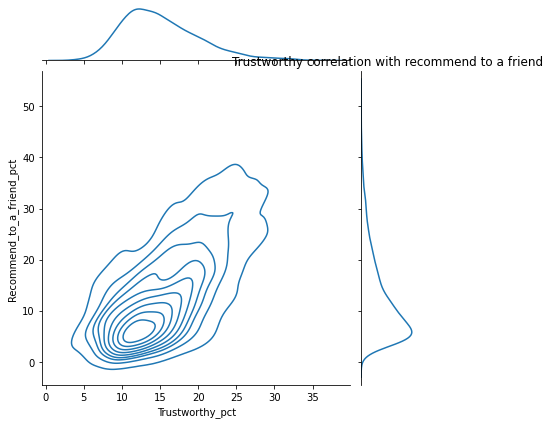

In [78]:
sns.jointplot(BAV_2019['Trustworthy_pct'], BAV_2019['Recommend_to_a_friend_pct'], kind = 'kde')
plt.title('Trustworthy correlation with recommend to a friend')
plt.show()

/Users/jerryroback/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


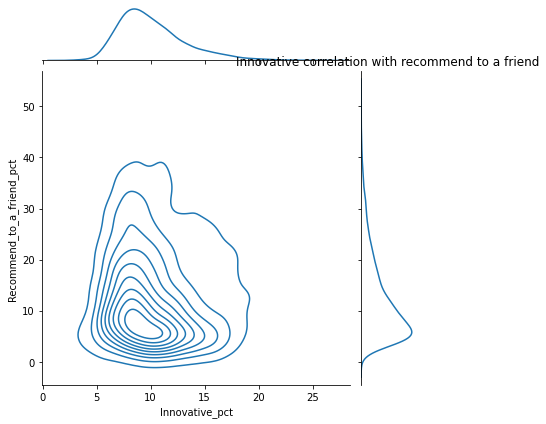

In [79]:
sns.jointplot(BAV_2019['Innovative_pct'], BAV_2019['Recommend_to_a_friend_pct'], kind = 'kde')
plt.title('Innovative correlation with recommend to a friend')
plt.show()

There are deffinitely some long-tail distributions for many of these attributes. While there are dense spots, it will be interesting to try to condence these features in the next phase.

### 4. Experiment

Before it's potentially lost, curious to know how significant are the year over year changes? We know there has been a push across the board in brands attempting to build their perception around social responsibility. How did this attribute change between 2018 and 2019 in the eyes of consumers? Was this observed change significant or expected?

In [80]:
sr_2019 = pd.DataFrame(BAV_2019_clean['Socially_Responsible_pct'])
sr_2018 = pd.DataFrame(BAV_2018_clean['Socially_Responsible_pct'])
sr_2018['Year'] = 2018
sr_2019['Year'] = 2019

In [81]:
sr_join = pd.concat([sr_2018, sr_2019])
sr_join.sample(10)

,Socially_Responsible_pct,Year
Marc`s,9.336987,2019
Equifax,10.890220,2019
Dole,10.600690,2018
Fashion Fair,9.257215,2018
Travelocity,8.837034,2018
Dell,9.614412,2019
Portugal,6.042883,2018
Xerox,8.509355,2018
Waggin` Train,9.137408,2019
Android Wear,10.631690,2018


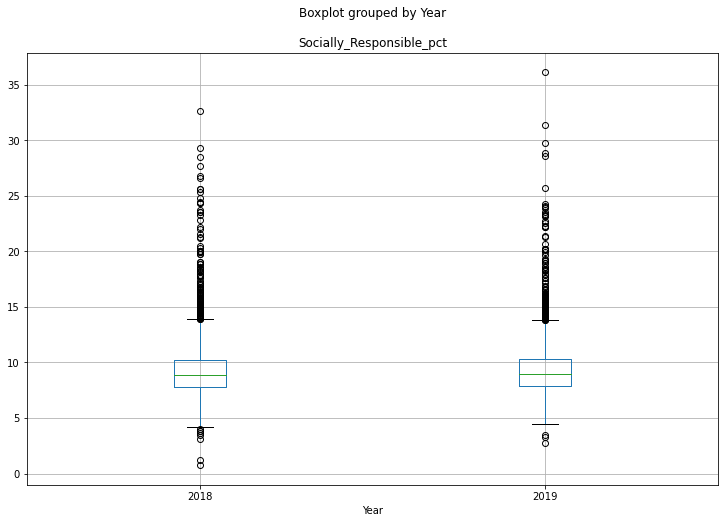

In [82]:
sr_join.boxplot(column='Socially_Responsible_pct', by='Year', figsize=(12, 8)) 
plt.show()

In [83]:
sr_join.groupby('Year').describe()

Socially_Responsible_pct                                          \
                        count      mean       std       min       25%   
Year                                                                    
2018                   2869.0  9.293771  2.597430  0.755704  7.774674   
2019                   2869.0  9.399162  2.580562  2.777488  7.899614   

                                   
           50%       75%      max  
Year                               
2018  8.907391  10.22609  32.5998  
2019  8.966401  10.27297  36.1012

Finding: Social Responsibility perception did rise across the board between 2018 and 2019. But is this change statistically significant?

In [84]:
#Is that increase in 2019 within an expected 95% confidence interval for 2018?
sr_mean_2019 = np.mean(BAV_2019_clean['Socially_Responsible_pct'])
sr_mean_2018 = np.mean(BAV_2018_clean['Socially_Responsible_pct'])
sr_std_2018 = np.std(BAV_2018_clean['Socially_Responsible_pct'])
se = sr_std_2018 / (np.sqrt(len(BAV_2018_clean)))

z = 1.96
conf = (se * z)
print(conf)

#Top Quintiles
print('Mean 2019: {}'.format(sr_mean_2019))
print('Mean 2018: {}'.format(sr_mean_2018))

print('Top range of the 95th percentile confidence interval for 2018 expected mean is: {}'.format(sr_mean_2018 + conf))

0.09502961139697137
Mean 2019: 9.399161850047387
Mean 2018: 9.293770507367574
Top range of the 95th percentile confidence interval for 2018 expected mean is: 9.388800118764545


Takeaway: The 2019 mean 'social responsibility' perception falls above the 95% confidence interval of expected values for 2018. This attribute change for 2019 can be viewed as statistically significant. In general, year-over-year changes can be seen as statistcally significant.

### 5. Summary and Save Outs

The identified target feature of 'Recommend to a Friend' is influenced by a number of features. While the Differentiation_c was found to play less of a role, the other aggrigate attributes of Strength, Relevance, Esteem and Knowledge are all top correlators, but other like Best Brand, Down to Earth, and Trustworthy are all contributors as well. In addition to the target feature, some significance was found in the year-over-year change between independant variables like Socially Responsible. This is good to know as as we move into the next phase.

In [85]:
BAV_2018 = pd.DataFrame(BAV_2018_clean)
BAV_2019 = pd.DataFrame(BAV_2019_clean)

BAV_2018['Year'] = 2018
BAV_2019['Year'] = 2019
BAV_join = pd.concat([BAV_2018, BAV_2019])

In [86]:
BAV_join.sample(5)

,Recommend_to_a_friend_pct,Energized_Differentiation_C,Relevance_C,Esteem_C,Knowledge_C,Brand_Stature_C,Brand_Strength_C,Different_pct,Distinctive_pct,Unique_pct,...,Stylish_pct,Traditional_pct,Trendy_pct,Trustworthy_pct,Unapproachable_pct,Up_To_Date_pct,Upper_Class_pct,Visionary_pct,Worth_More_pct,Year
Excel Telecom,3.234112,0.640163,2.071372,0.324000,0.990769,0.321009,1.326016,10.151360,11.16680,10.468190,...,6.298985,8.695670,12.377940,12.74178,7.570281,11.195790,8.941732,11.222370,6.210151,2018
ADT Security,11.879330,0.627672,2.272620,0.922739,2.830021,2.611371,1.426461,7.809969,10.68087,7.609741,...,6.395462,9.217343,10.121420,37.74659,4.472166,13.079000,12.092930,12.727520,8.650723,2018
Nature Made,20.564039,0.501255,3.355567,0.657180,3.256071,2.139824,1.681994,7.646706,10.28474,6.772410,...,3.442415,10.260980,9.968698,21.63928,3.360622,10.791130,4.413055,9.169393,6.197250,2018
Arrow,7.198852,0.540524,2.455308,0.452072,1.906575,0.861910,1.327154,8.091413,12.41109,8.459471,...,15.031180,9.721975,11.916950,14.80333,4.188756,8.743823,9.543100,7.833674,6.017448,2019
FinancialTimes.com,5.278493,0.561148,2.522055,0.458129,1.089888,0.499309,1.415245,9.280112,11.03687,7.541264,...,5.648880,8.619661,14.767280,15.86675,5.901733,16.130091,13.687290,12.819090,6.145274,2019


In [87]:
BAV_join.to_csv("../data/BAV_join.csv")
BAV_2018.to_csv("../data/BAV_2018_EDA.csv")
BAV_2019.to_csv("../data/BAV_2019_EDA.csv")